In [3676]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as plo
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
plo.init_notebook_mode(connected=True)
import squarify    
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,classification_report,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold 
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform 
import warnings
warnings.filterwarnings('ignore') 

In [3677]:
data = pd.read_csv(r"C:\Users\Praveen\Downloads\archive\diabetes.csv") 


In [3678]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3679]:
Diabetes = data[(data['Outcome'] != 0)]
Healthy = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def tv_count():
    Barchat = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=100),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['green', 'orange'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Outcome Count')

    fig = dict(data = [Barchat], layout=layout)
    plo.iplot(fig)

#------------PERCENTAGE-------------------
def tv_percent():
    Piechart = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['green', 'orange'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Outcome Percentage')

    fig = dict(data = [Piechart], layout=layout)
    plo.iplot(fig)


In [3680]:
tv_count() 
tv_percent()

In [3681]:
#Cal of median value 
def median_cal(data,tar_var,indep_var):
    #Getting the specific values not null
    temp = data[data[indep_var].notnull()]
    #Grouping tHE VALUES based on median
    temp = temp[[indep_var,tar_var]].groupby([tar_var])[[indep_var]].median().reset_index() 
    return temp
    

In [3682]:
def median_imp(data,tar_var,indep_var,indep_var_0,indep_var_1):
    #Loop run till the length of the dataset
    for i in range(len(data)):
        #Check the Outcome variable with 0 and indep_variable that sync with 0
        if data.loc[i,tar_var] == 0 and data.loc[i,indep_var] == 0: 
            data.loc[i,indep_var] = indep_var_0
        #Check the Outcome variable with 1 and indep_variable that sync with 1
        elif data.loc[i,tar_var] == 1 and data.loc[i,indep_var] ==1:
            data.loc[i,indep_var] = indep_var_1

In [3683]:
median_cal(data,"Outcome","Glucose")

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [3684]:
median_imp(data,"Outcome","Glucose",data.loc[0,"Glucose"],data.loc[1,"Glucose"])

In [3685]:
median_cal(data,"Outcome","BloodPressure")

,Outcome,BloodPressure
0,0,70.0
1,1,74.0


In [3686]:
median_imp(data,"Outcome","BloodPressure",data.loc[0,"BloodPressure"],data.loc[1,"BloodPressure"])

In [3687]:
median_cal(data,"Outcome","SkinThickness")

,Outcome,SkinThickness
0,0,21.0
1,1,27.0


In [3688]:
median_imp(data,"Outcome","SkinThickness",data.loc[0,"SkinThickness"],data.loc[1,"SkinThickness"])

In [3689]:
median_cal(data,"Outcome","Insulin")

,Outcome,Insulin
0,0,39.0
1,1,0.0


In [3690]:
median_imp(data,"Outcome","Insulin",data.loc[0,"Insulin"],data.loc[1,"Insulin"])

In [3691]:
median_cal(data,"Outcome","BMI")

,Outcome,BMI
0,0,30.05
1,1,34.25


In [3692]:
median_imp(data,"Outcome","BMI",data.loc[0,"BMI"],data.loc[1,"BMI"])

In [3693]:
#EDA Phase 

In [3694]:
def plot_feat1_feat2(feat1, feat2) :  
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers', 
        marker = dict(color = 'orange',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = 'green',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    plo.iplot(fig)


In [3695]:
plot_feat1_feat2('Glucose','Age')

In [3696]:
data.loc[:,"N1"] = 1
data.loc[(data['Age']<=30) & (data['Glucose']<=120),'N1']= 0
data.loc[(data['Age']>30) & (data['Age']<48) & (data['Glucose']<=88),'N1']= 0
data.loc[(data['Age']>=63) & (data['Glucose']<=142),'N1']= 0

In [3697]:
data.loc[:,'N2']= 1
data.loc[(data['BMI']<=30),'N2']=0

In [3698]:
plot_feat1_feat2('Pregnancies','Age')

In [3699]:
data.loc[:,'N3']= 1
data.loc[(data['Age']<=27) & (data['Pregnancies']<=6),'N3']= 0
data.loc[(data['Age']>60) & (data['Pregnancies']>7.5),'N3']= 0

In [3700]:
plot_feat1_feat2('Glucose','BloodPressure')

In [3701]:
data.loc[:,'N4']= 1
data.loc[(data['Glucose']<=105) & (data['BloodPressure']<=80),'N4']= 0
data.loc[(data['Glucose']<=105) & (data['BloodPressure']>80),'N4']= 0

In [3702]:
data.loc[:,'N5']= 1
data.loc[(data['SkinThickness']<=20) ,'N5']= 0

In [3703]:
plot_feat1_feat2('SkinThickness','BMI')

In [3704]:
data.loc[:,'N6']= 1
data.loc[(data['BMI']<30) & (data['SkinThickness']<=35),'N6']= 0

In [3705]:
plot_feat1_feat2('Glucose','BMI')

In [3706]:
data.loc[:,'N7']= 1
data.loc[(data['Glucose']<=105) & (data['BMI']<=30),'N7']= 0
data.loc[(data['Glucose']<=105) & (data['BMI']>=40),'N7']= 0

In [3707]:
data.loc[:,'N9']=1
data.loc[(data['Insulin']<200),'N9']= 0

In [3708]:
data.loc[:,'N10']= 1
data.loc[(data['BloodPressure']<80),'N10']= 0

In [3709]:
data.loc[:,'N11']= 1
data.loc[(data['Pregnancies']<4) & (data['Pregnancies']!=0) ,'N11']= 0

In [3710]:
data


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N1,N2,N3,N4,N5,N6,N7,N9,N10,N11
0,6,148,72,35,0,33.6,0.627,50,1,1,1,1,1,1,1,1,0,0,1
1,1,85,66,29,0,26.6,0.351,31,0,0,0,1,0,1,0,0,0,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1,0,1,1,0,0,1,0,0,1
3,1,89,66,23,94,28.1,0.167,21,0,0,0,0,0,1,0,0,0,0,0
4,0,137,40,35,168,43.1,2.288,33,1,1,1,1,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0,1,0,0,1,1,1,0,0,1
764,2,122,70,27,0,36.8,0.340,27,0,1,1,0,1,1,1,1,0,0,0
765,5,121,72,23,112,26.2,0.245,30,0,1,0,1,1,1,0,1,0,0,1
766,1,126,60,0,0,30.1,0.349,47,1,1,1,1,1,0,1,1,0,0,0


In [3711]:
data['N0'] = data['BMI'] * data['SkinThickness']

data['N8'] =  data['Pregnancies'] / data['Age']

data['N13'] = data['Glucose'] / data['DiabetesPedigreeFunction']

data['N12'] = data['Age'] * data['DiabetesPedigreeFunction']

data['N14'] = data['Age'] / data['Insulin']

In [3712]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N1,...,N6,N7,N9,N10,N11,N0,N8,N13,N12,N14
0,6,148,72,35,0,33.6,0.627,50,1,1,...,1,1,0,0,1,1176.0,0.120000,236.044657,31.350,inf
1,1,85,66,29,0,26.6,0.351,31,0,0,...,0,0,0,0,0,771.4,0.032258,242.165242,10.881,inf
2,8,183,64,0,0,23.3,0.672,32,1,1,...,0,1,0,0,1,0.0,0.250000,272.321429,21.504,inf
3,1,89,66,23,94,28.1,0.167,21,0,0,...,0,0,0,0,0,646.3,0.047619,532.934132,3.507,0.223404
4,0,137,40,35,168,43.1,2.288,33,1,1,...,1,1,0,0,1,1508.5,0.000000,59.877622,75.504,0.196429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0,...,1,1,0,0,1,1579.2,0.158730,590.643275,10.773,0.350000
764,2,122,70,27,0,36.8,0.340,27,0,1,...,1,1,0,0,0,993.6,0.074074,358.823529,9.180,inf
765,5,121,72,23,112,26.2,0.245,30,0,1,...,0,1,0,0,1,602.6,0.166667,493.877551,7.350,0.267857
766,1,126,60,0,0,30.1,0.349,47,1,1,...,1,1,0,0,0,0.0,0.021277,361.031519,16.403,inf


In [3713]:
data.loc[:,'N15']= 1
data.loc[(data['N0']<1034) ,'N15']= 0

In [3714]:
y = pd.DataFrame(data["Outcome"])
x= data.drop("Outcome",axis = 1)

In [3715]:
encoder = LabelEncoder()
for col in y.columns:
    y[col] = encoder.fit_transform(y[col])
print(y)

     Outcome
0          1
1          0
2          1
3          0
4          1
..       ...
763        0
764        0
765        0
766        1
767        0

[768 rows x 1 columns]


In [3716]:
y = y["Outcome"]

In [3717]:
df = data[["N1","N2","N3","N4","N5","N6"]]
#df = data[["N1","N2","N3","N4"]]
x=df

In [3718]:

for col in x.columns:
    x[col]= encoder.fit_transform(x[col])
    
    

In [3719]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state= 0)

In [3720]:
bagging = BaggingClassifier(DecisionTreeClassifier(random_state= 0 ),n_estimators = 300,
                           max_samples = 200, bootstrap=True,n_jobs=-1,random_state=0,
                            oob_score = True)
bagging.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                  max_samples=200, n_estimators=300, n_jobs=-1, oob_score=True,
                  random_state=0)

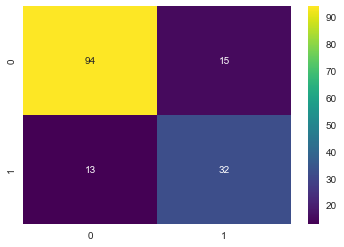

In [3721]:
confusion_matrix = confusion_matrix(bagging.predict(x_test),y_test)
sns.heatmap(confusion_matrix,annot=True,fmt= "0.2g",cmap = "viridis")
plt.show()

In [3722]:
print(classification_report(y_test,bagging.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       107
           1       0.71      0.68      0.70        47

    accuracy                           0.82       154
   macro avg       0.79      0.78      0.78       154
weighted avg       0.82      0.82      0.82       154

